In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

In [2]:
df = pd.read_hdf('../car.h5')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106494 entries, 0 to 160615
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 77.0+ MB


In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
df.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [4]:
# Target variable has two currencys
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [5]:
def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5

In [6]:
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

In [7]:
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

5832640


0

In [8]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

In [9]:
def get_X_y_and_cros_val(model, feats):
    X = df[ feats ]
    y = df['price_value_PLN']
    
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    
    return max(scores) * -1, np.std(scores)

In [10]:
#Dummy model for reference
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

39702.02572163561

# feature engineering 

In [11]:
# all new features will be tested on the same mosel
model = DecisionTreeRegressor(max_depth=5, random_state=0)

In [12]:
# only bool feats first sice their require no additional work
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

get_X_y_and_cros_val(model, feats)

(24930.650454503917, 99.36990415182366)

In [13]:
df.select_dtypes([np.object]).sample(20)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
125131,"[Osobowe, Mazda, 6, Mazda 6 III (2012-)]","18:44, 2 marca 2018",PLN,"Cena Brutto, Do negocjacji","Świętochłowice, Śląskie",-1,Osoba prywatna,5,-1,Mazda,-1,-1,4,-1,-1,1 czerwiec 2017,-1,28 000 km,-1,2015,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Sedan,Tak,-1,Manualna,-1,-1,-1,-1,Tak,Osoby prywatnej,192 KM,-1,-1,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,6,2 500 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Czarny,-1,-1,Używane,III (2012-),-1,-1,-1,-1,-1,-1
133184,"[Osobowe, Audi, A3, Audi A3 8P (2003-2012)]","14:42, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji","Szczecin, Zachodniopomorskie, Północ",-1,Osoba prywatna,5,-1,Audi,-1,-1,5,-1,-1,7 sierpień 2007,-1,159 703 km,-1,2007,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kompakt,Tak,Tak,Manualna,-1,-1,-1,-1,Tak,Osoby prywatnej,105 KM,-1,Belgia,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,A3,1 896 cm3,-1,-1,-1,-1,-1,-1,Tak,-1,-1,Inny kolor,-1,-1,Używane,8P (2003-2012),-1,-1,-1,Tak,-1,-1
139587,"[Osobowe, Volkswagen, Golf Plus]","17:03, 4 marca 2018",PLN,"Cena Brutto, Do negocjacji","Kraśnik, kraśnicki, Lubelskie",-1,Osoba prywatna,5,-1,Volkswagen,-1,-1,5,-1,-1,-1,-1,189 000 km,-1,2006,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Minivan,Tak,Tak,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,105 KM,-1,Niemcy,-1,-1,-1,Diesel,-1,-1,-1,-1,-1,-1,-1,Golf Plus,1 900 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Srebrny,-1,-1,Używane,-1,-1,-1,-1,Tak,-1,-1
110674,"[Osobowe, Hyundai, I30, Hyundai I30 III (2017-)]","13:31, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT","Al. Jana Pawła II 19 A - 87-800 Włocławek, Kuj...",Auto Strefa Sp. z o.o.,Dealer,5,-1,Hyundai,-1,-1,5,-1,-1,-1,-1,1 km,Tak,2018,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,Tak,-1,-1,Na przednie koła,-1,Kompakt,Tak,-1,Manualna,-1,-1,-1,-1,-1,Firmy,100 KM,-1,Polska,-1,-1,-1,Benzyna,Tak,-1,-1,-1,-1,-1,-1,I30,1 390 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Niebieski,-1,-1,Nowe,III (2017-),-1,-1,-1,Tak,-1,-1
159930,"[Osobowe, Honda, Civic, Honda Civic X (2017-)]","10:46, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT","ul. Oleska 141a - 45-231 Opole, Opolskie (Polska)",AVIA Sp.J. Autoryzowany Dealer Marki Honda,Dealer,5,-1,Honda,-1,-1,5,-1,-1,-1,-1,1 km,Tak,2017,-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Kompakt,-1,-1,Automatyczna bezstopniowa (CVT),-1,-1,-1,-1,-1,Firmy,182 KM,-1,Polska,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,Civic,1 500

In [14]:
# feats worth merging (decided after firs feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year'
          }

# numerical feats
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date feats
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja']

black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency']

In [15]:
def print_by_line(lst):
    for l in lst:
        print(l)

In [16]:
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]
    
cat_feats

['seller_address',
 'seller_name',
 'seller_type',
 'param_uszkodzony',
 'param_marka-pojazdu',
 'param_model',
 'param_engine-code',
 'param_first-registration',
 'param_country-of-origin',
 'param_gearbox',
 'param_faktura-vat',
 'param_vin',
 'param_perłowy',
 'param_homologacja-ciężarowa',
 'param_service-record',
 'param_metallic',
 'param_leasing-concession',
 'param_color',
 'param_financing-option',
 'param_original-owner',
 'param_vat-marża',
 'param_kategoria',
 'param_co2-emissions',
 'param_leasing',
 'param_mileage',
 'param_zarejestrowany-jako-zabytek',
 'param_napęd',
 'param_typ',
 'param_metalik',
 'param_pierwszy-właściciel',
 'param_skrzynia-biegów',
 'param_vat-discount',
 'param_no-accident',
 'param_particle-filter',
 'param_zarejestrowany-w-polsce',
 'param_oferta-od',
 'param_make',
 'param_kraj-pochodzenia',
 'param_engine-power',
 'param_year',
 'param_serwisowany-w-aso',
 'param_rodzaj-paliwa',
 'param_możliwość-finansowania',
 'param_registered-in-poland',
 

In [17]:
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_first-registration__cat',
 'param_country-of-origin__cat',
 'param_gearbox__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_color__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_co2-emissions__cat',
 'param_leasing__cat',
 'param_mileage__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_make__cat

In [18]:
# bool and cat feats now. You can see the improvement
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats)

(20171.950836919234, 127.59371308535088)

In [19]:
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [20]:
df['param_engine-capacity'].unique()

array([-1, '1 600 cm3', '1 995 cm3', '1 364 cm3', '3 000 cm3',
       '2 200 cm3', '2 953 cm3', '1 598 cm3', '2 143 cm3', '1 700 cm3',
       '1 395 cm3', '2 500 cm3', '1 400 cm3', '1 200 cm3', '1 910 cm3',
       '1 997 cm3', '1 968 cm3', '1 896 cm3', '1 686 cm3', '2 698 cm3',
       '1 975 cm3', '2 400 cm3', '1 242 cm3', '1 998 cm3', '1 500 cm3',
       '2 231 cm3', '3 600 cm3', '2 000 cm3', '1 800 cm3', '1 595 cm3',
       '1 498 cm3', '1 100 cm3', '1 300 cm3', '998 cm3', '1 248 cm3',
       '1 956 cm3', '1 461 cm3', '1 499 cm3', '1 999 cm3'], dtype=object)

In [21]:
def check_if_complementing(feat1, feat2): #  count of instances when data only in that column
    has_data = []
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data.append('both')        
        elif df[feat1].iloc[i] != -1:
            has_data.append(feat1)
        elif df[feat2].iloc[i] != -1:
            has_data.append(feat2)
    print(Counter(has_data))
    print()

In [22]:
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)

Counter({'param_liczba-drzwi': 96594, 'param_door-count': 74})

Counter({'param_przebieg': 106057, 'param_mileage': 82})

Counter({'param_pojemność-skokowa': 101389, 'param_engine-capacity': 79})

Counter({'param_emisja-co2': 2086, 'param_co2-emissions': 3})

Counter({'param_rok-produkcji': 106302, 'param_year': 83})



In [23]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]

In [24]:
#marge data in doubles dictionary
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)

In [25]:
def get_rid_of_unit_and_dec(val):
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val

In [26]:
print_by_line(num_feats)

param_liczba-miejsc
param_liczba-drzwi
param_przebieg
param_moc
param_pojemność-skokowa
param_emisja-co2
param_wartość-wykupu
param_liczba-pozostałych-rat
param_miesięczna-rata
param_opłata-początkowa


In [27]:
num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)
num_feats = [x for x in df.columns if num_feat_prefix in x]

In [28]:
df[num_feats].head()

,param_liczba-miejsc__num,param_liczba-drzwi__num,param_przebieg__num,param_moc__num,param_pojemność-skokowa__num,param_emisja-co2__num,param_wartość-wykupu__num,param_miesięczna-rata__num,param_opłata-początkowa__num,param_liczba-pozostałych-rat__num,param_rok-produkcji__num
0,-1,4,1,90,898,-1,-1,-1,-1,-1,2018
2,5,5,209533,115,1560,-1,-1,-1,-1,-1,2011
3,5,5,30500,262,3000,-1,-1,-1,-1,-1,2015
4,-1,-1,129500,110,1560,-1,-1,-1,-1,-1,2009
5,5,5,29100,310,1984,-1,-1,-1,-1,-1,2017


In [29]:
feats

['feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_zmieniarka-cd',
 'feature_szyberdach',
 'feature_isofix',
 'feature_asystent-pasa-ruchu',
 'feature_alufelgi',
 'feature_bluetooth',
 'feature_nawigacja-gps',
 'featur

In [30]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
get_X_y_and_cros_val(model, feats)

(14303.899679527995, 147.9443606365125)

In [31]:
# for num_feat in num_feats:
#     if num_feat != 'param_przebieg__num': # Takes too long
#         plt.figure(figsize=(20,10))
#         ax = sns.barplot(x=num_feat, y='price_value_PLN', data=df, color='#3498db');
#         plt.xticks(rotation=90);

In [32]:
# plt.figure(figsize=(20,10))
# ax = sns.barplot(x='param_przebieg__num', y='price_value_PLN', data=df, color='#33ccff');
# plt.xticks(rotation=90);

In [33]:
# cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat']
# for cat_feat in cat_feats:
#     if cat_feat not in cat_no_plot:
#         cat_name = cat_feat[:-len(cat_feat_prefix)]
#         plt.figure(figsize=(20,10))
#         sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
#         plt.xticks(rotation=90);

# Model optimization

In [34]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
X = df[ feats ]
y = df['price_value_PLN']
feats

['feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_zmieniarka-cd',
 'feature_szyberdach',
 'feature_isofix',
 'feature_asystent-pasa-ruchu',
 'feature_alufelgi',
 'feature_bluetooth',
 'feature_nawigacja-gps',
 'featur

In [35]:
model = DecisionTreeRegressor(max_depth=10, random_state=0)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([10709.668555720686, 10797.00368115397, 10523.236583806101],
 114.17955055120929)

In [36]:
model = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=0)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([9309.160341835102, 9542.833918638577, 9509.284894984443], 103.16045444812764)

In [37]:
model = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([9108.269658285575, 9314.353495718038, 9247.042388030768], 85.80287730859838)

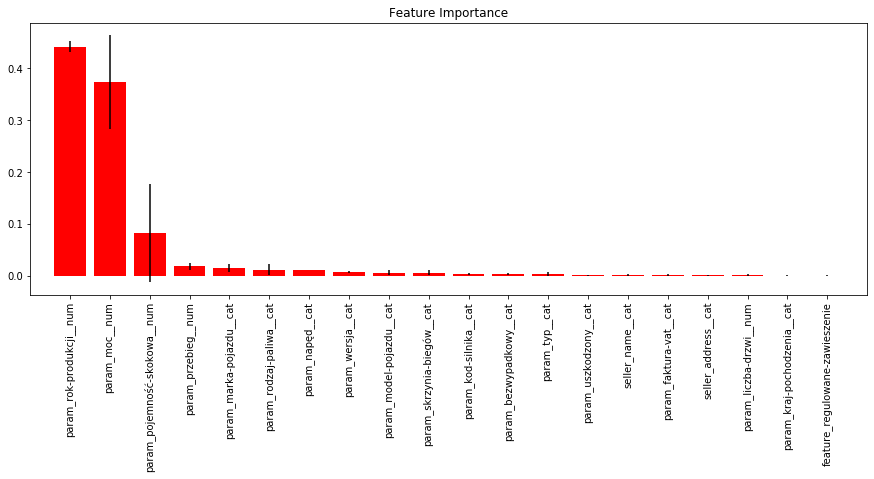

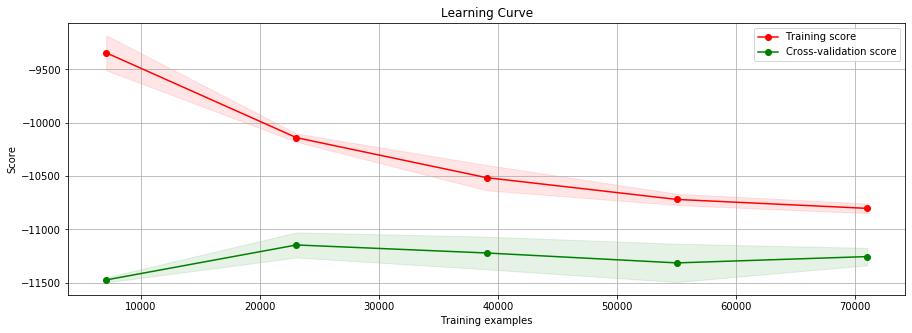

In [38]:
model = RandomForestRegressor(max_depth=7, n_estimators=20, random_state=0)
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');

In [39]:
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [40]:
m = RandomForestRegressor(max_depth=7, n_estimators=20, random_state=0)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.7377 ± 0.0110,param_rok-produkcji__num
0.4359 ± 0.0019,param_moc__num
0.0531 ± 0.0026,param_pojemność-skokowa__num
0.0362 ± 0.0015,param_przebieg__num
0.0222 ± 0.0014,param_marka-pojazdu__cat
0.0184 ± 0.0005,param_napęd__cat
0.0164 ± 0.0012,param_rodzaj-paliwa__cat
0.0113 ± 0.0005,param_wersja__cat
0.0101 ± 0.0002,param_skrzynia-biegów__cat
0.0058 ± 0.0002,param_model-pojazdu__cat


In [41]:
xgb_params = {
    'max_depth' :10,
    'n_estimators' :50,
    'learning_rate': 0.1,
    'seed': 0
}

In [42]:
model = xgb.XGBRegressor(**xgb_params)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([7126.039483345122, 7294.96869241024, 7174.615130049278], 71.00989845011998)

In [43]:
m = xgb.XGBRegressor(**xgb_params)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.4941 ± 0.0066,param_rok-produkcji__num
0.3523 ± 0.0043,param_moc__num
0.1207 ± 0.0034,param_przebieg__num
0.0560 ± 0.0026,param_pojemność-skokowa__num
0.0433 ± 0.0024,param_marka-pojazdu__cat
0.0174 ± 0.0009,param_rodzaj-paliwa__cat
0.0164 ± 0.0008,param_wersja__cat
0.0157 ± 0.0008,seller_name__cat
0.0129 ± 0.0003,param_napęd__cat
0.0117 ± 0.0005,param_model-pojazdu__cat


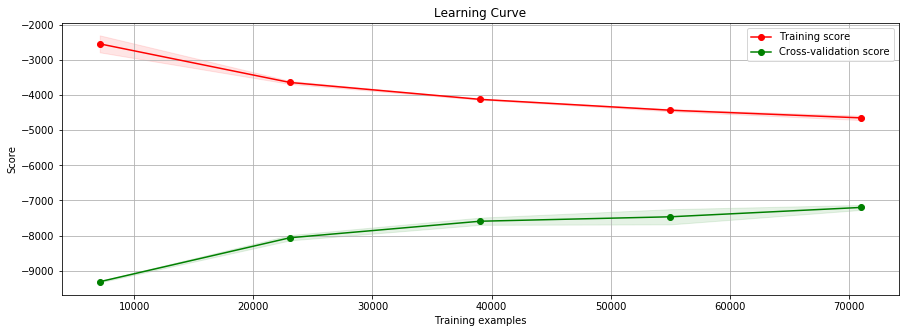

In [44]:
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');

In [45]:
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [61]:
X = df[feats].values
y = df['price_value_PLN'].values

def obj_func(params):
    print("Training with params: ")
    print(params)
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))
    
    print("Score: {}".format(score))
    return {'loss' : score, 'status': STATUS_OK}

xgb_reg_params = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_btree', 0.5, 1, 0.05),
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'seed': 0,
}

trials = Trials()
best = fmin(obj_func, xgb_reg_params, algo=partial(tpe.suggest, n_startup_jobs=10), max_evals=30, trials=trials)

best

Training with params:                                 
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9}
Score: 6523.724183133952                              
Training with params:                                                          
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.25, 'max_depth': 15, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.55}
Score: 7437.557435228919                                                       
Training with params:                                                          
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.7000000000000001}
Score: 7652.804715141781                                                       
Training with params:                                                          
{'colsample_by

Score: 6666.643113932448                                                       
Training with params:                                                          
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.7000000000000001}
Score: 6736.560817032521                                                       
Training with params:                                                          
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 14, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9}
Score: 6621.144607301387                                                       
Training with params:                                                          
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 1.0}
Score: 8222.130984363346                    

{'colsample_btree': 0.8,
 'learning_rate': 1,
 'max_depth': 9,
 'subsample': 0.8500000000000001}

In [66]:
xgb_params = {
    'max_depth' :10,
    'n_estimators' :50,
    'learning_rate': 0.1,
    'seed': 0
}

In [67]:
xgb_params_opt = {
    'max_depth' : 9,
    'n_estimators' : 100,
    'learning_rate': 1,
    'seed': 0,
    'colsample_btree': 0.8,
    'subsample': 0.85
}

In [68]:
model = xgb.XGBRegressor(**xgb_params)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([7126.039483345122, 7294.96869241024, 7174.615130049278], 71.00989845011998)

In [69]:
model = xgb.XGBRegressor(**xgb_params_opt)
scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
[x * -1 for x in scores], np.std(scores)

([11124.357551418263, 11394.515125285336, 12396.5906099726], 547.28799517941)

In [64]:
m = model = xgb.XGBRegressor(**xgb_params_opt)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.6639 ± 0.0107,param_rok-produkcji__num
0.5064 ± 0.0178,param_moc__num
0.1939 ± 0.0019,param_przebieg__num
0.1065 ± 0.0031,param_marka-pojazdu__cat
0.0575 ± 0.0029,param_pojemność-skokowa__num
0.0559 ± 0.0018,param_rodzaj-paliwa__cat
0.0510 ± 0.0003,param_model-pojazdu__cat
0.0463 ± 0.0022,seller_name__cat
0.0407 ± 0.0033,param_wersja__cat
0.0357 ± 0.0006,param_napęd__cat


# Train test vlidate

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
model = xgb.XGBRegressor(**xgb_params_opt)

cv = KFold(n_splits=2, random_state=0, shuffle=True)
scores = []
for train_idx, test_idx in cv.split(y_train):
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_pred = model.predict(X_train.iloc[test_idx])
    
    score = mean_absolute_error(y_train.iloc[test_idx], y_pred)
    scores.append(score)
    
[x * -1 for x in scores], np.std(scores)

([-7676.219286325071, -7656.93172270366], 9.643781810705605)

In [52]:
y_pred_val = model.predict(X_test)
mean_absolute_error(y_pred_val, y_test)

7616.310319146334